# TP2: Modelado sobre dataset Fashion MNIST

## Librerías

Fuente: https://pjreddie.com/projects/mnist-in-csv/

In [1]:
import pandas as pd
import os
import gzip
import numpy as np
import time
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import glob
import re

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from PIL import Image, ImageOps
from itertools import product
from random import sample
import pickle

Correr una sola vez para descargar toda la data luego mutear todo el chunk. 

In [2]:
# def download_gz_from_url(url, output_folder): 
#     file_name = url.split("/")[-1]
#     r = requests.get(url, stream=True)
#     with open(output_folder+"/"+file_name, 'wb') as f:
#         for chunk in r.raw.stream(1024, decode_content=False):
#             if chunk:
#                 f.write(chunk)

# output_folder= "./data"
                
# from pathlib import Path
# Path(output_folder).mkdir(parents=True, exist_ok=True)
                
# urls = ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz", #x_train
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz", #y_train
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz", #x_test
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz" #y_test
#        ]
                
# for url in tqdm(urls):
#     download_gz_from_url(url,output_folder)

## Carga de Datos

In [2]:
import mnist_fashion_reader as mnist

X_train, y_train = mnist.load_mnist('data/', kind='train') #devuelve amigables objetos de Pandas
X_test, y_test = mnist.load_mnist('data/', kind='t10k') #devuevle amigables objetos de Pandas

## Punto 1: Exploración del dataset

Realizar una breve descripción del dataset. 

* ¿Qué cantidad de datos tiene este conjunto?

* ¿Cuántos atributos? 

* ¿Qué rangos de valores toman los atributos?

* ¿Qué cantidad de clases hay para clasificar?

* ¿Están balanceadas?

* Realizar un gráfico donde se muestran ejemplos de las clases (Puede ir a un anexo).

### Cantidad de datos del conjunto

In [3]:
df_entrenamiento = pd.concat([X_train.reset_index(drop=True), y_train], axis=1)
df_test = pd.concat([X_test.reset_index(drop=True), y_test], axis=1)
df_completo = pd.concat([df_entrenamiento, df_test])

In [5]:
print('Entrenamiento:', df_entrenamiento.shape,'  +  ' ,'Test:', df_test.shape, '  -->  ' , 'Completo:', df_completo.shape)

Entrenamiento: (60000, 785)   +   Test: (10000, 785)   -->   Completo: (70000, 785)


In [6]:
print(f"El dataset completo posee {len(df_completo)} registros. Cada registro corresponde a una imagen del dataset.")

El dataset completo posee 70000 registros. Cada registro corresponde a una imagen del dataset.


### Atributos

#### Cantidad de atributos

In [7]:
print(f"Cada atributo representa el valor de cada uno de los pixeles de cada imagen. Dado que cada imagen tiene un formato de 28 x 28 pixeles en escala de grises, el dataset posee {len(df_completo.columns)-1} atributos por registro, correspondientes al valor en escala de gris de cada pixel que compone la imagen")

print("+ UN (1) atributo con valores de 0 a 9 correspondiente a las clases a clasificar" )

Cada atributo representa el valor de cada uno de los pixeles de cada imagen. Dado que cada imagen tiene un formato de 28 x 28 pixeles en escala de grises, el dataset posee 784 atributos por registro, correspondientes al valor en escala de gris de cada pixel que compone la imagen
+ UN (1) atributo con valores de 0 a 9 correspondiente a las clases a clasificar


In [8]:
28*28

784

#### Rangos de valores

In [9]:
max_val = df_completo.max().max()
min_val = df_completo.min().min()

In [10]:
print(f"El valor mínimo de los atributos es {min_val} , y el máximo es {max_val}. Cada valor es un integer entre {min_val} y {max_val}")

El valor mínimo de los atributos es 0 , y el máximo es 255. Cada valor es un integer entre 0 y 255


#### Clases a clasificar

In [11]:
clases = np.sort(df_completo[0].unique())

clases

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [12]:
print(f"El dataset está compuesto por {len(clases)} clases")

El dataset está compuesto por 10 clases


##### N de clases

In [13]:
print(f"Las clases son: {clases}")

Las clases son: [0 1 2 3 4 5 6 7 8 9]


##### Balanceo de clases

In [14]:
Q = df_completo[0].value_counts().rename("Cant")
P = 100*df_completo[0].value_counts(normalize=True).rename("%")

pd.concat([Q, P], axis=1).sort_index()


,Cant,%
0,7000,10.0
1,7000,10.0
2,7000,10.0
3,7000,10.0
4,7000,10.0
5,7000,10.0
6,7000,10.0
7,7000,10.0
8,7000,10.0
9,7000,10.0


##### Grafico donde se muestran ejemplos de las clases (Puede ir a un anexo)

1er Ejemplo:

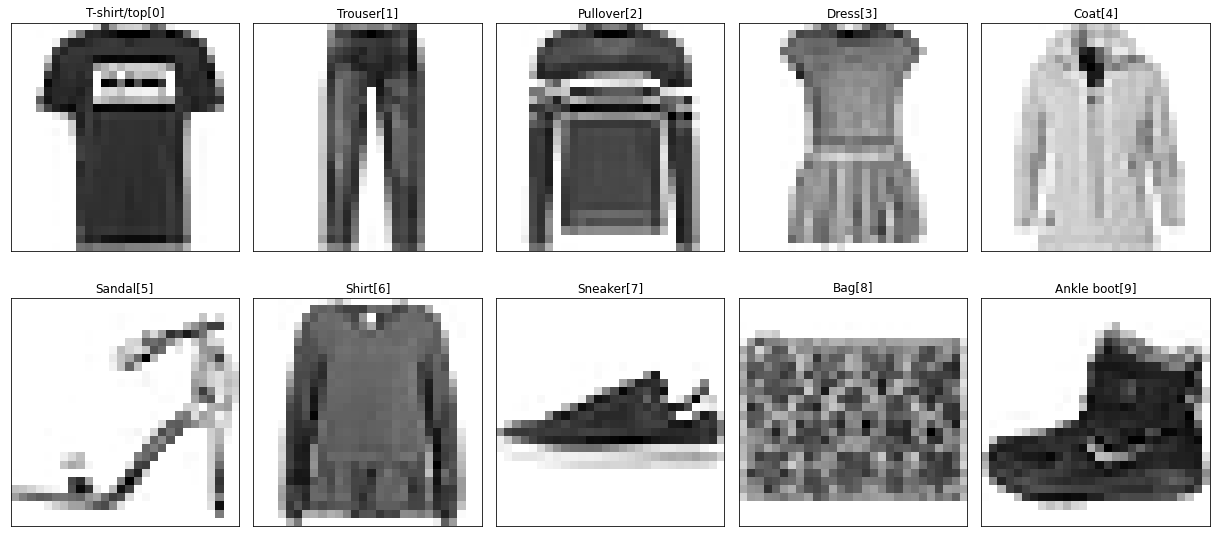

In [15]:
clases = np.sort(df_completo[0].unique())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Ejemplo 1
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_train == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_train[filtro_i].iloc[0]).reshape(28,28),cmap='binary')
plt.tight_layout()

2do Ejemplo:

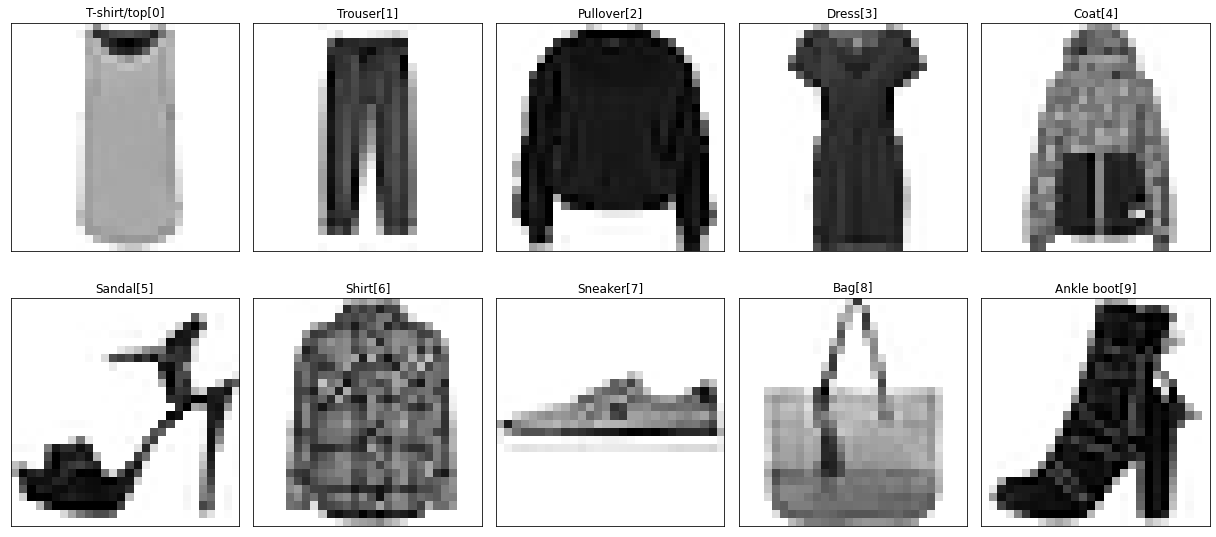

In [16]:
## Ejemplo 2
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_train == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_train[filtro_i].iloc[1]).reshape(28,28),cmap='binary')
plt.tight_layout()

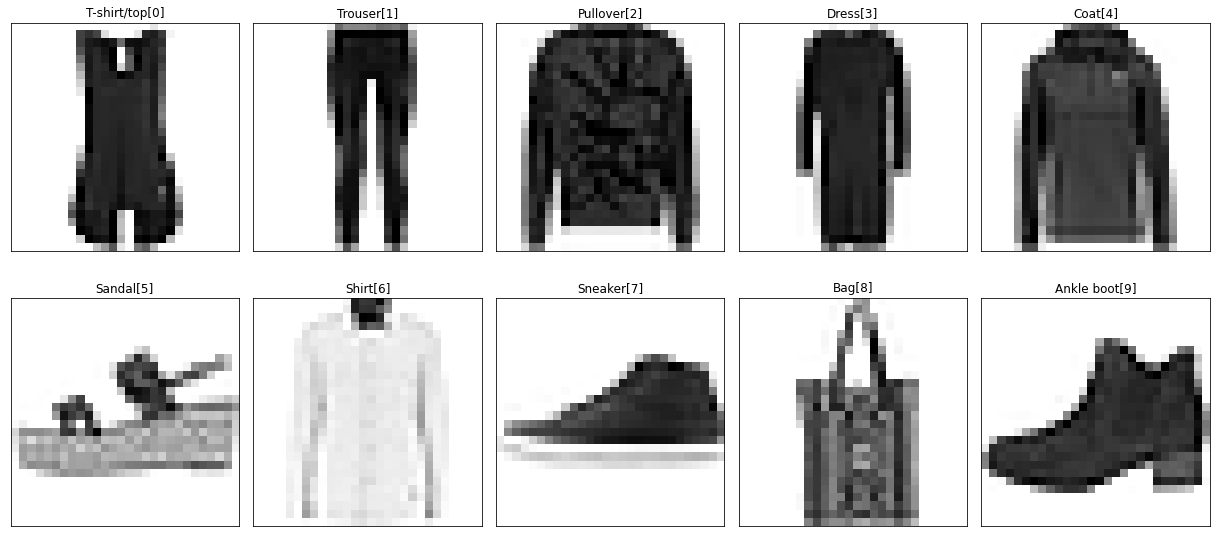

In [17]:
## Ejemplo 3
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_train == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_train[filtro_i].iloc[2]).reshape(28,28),cmap='binary')
plt.tight_layout()

## Punto 2: Separación en desarrollo y testeo

Separación de datos respetando la división presente en el github oficial de desarrollo y testeo

In [18]:
X_train.shape

(60000, 784)

In [19]:
y_train.shape

(60000,)

In [20]:
X_test.shape

(10000, 784)

In [21]:
y_test.shape

(10000,)

In [22]:
Q1 = y_train.value_counts().rename("Cant")
P1 = 100*y_train.value_counts(normalize=True).rename("%")

pd.concat([Q1, P1], axis=1).sort_index().rename_axis('train')

,Cant,%
train,,
0,6000,10.0
1,6000,10.0
2,6000,10.0
3,6000,10.0
4,6000,10.0
5,6000,10.0
6,6000,10.0
7,6000,10.0
8,6000,10.0


In [23]:
Q2 = y_test.value_counts().rename("Cant")
P2 = 100*y_test.value_counts(normalize=True).rename("%")

pd.concat([Q2, P2], axis=1).sort_index().rename_axis('test')

,Cant,%
test,,
0,1000,10.0
1,1000,10.0
2,1000,10.0
3,1000,10.0
4,1000,10.0
5,1000,10.0
6,1000,10.0
7,1000,10.0
8,1000,10.0


## Punto 3: Separación del conjunto de desarrollo en entrenamiento y validación

Conjunto de entrenamiento (85.71%):
* x_train, y_train = 80% del conjunto de entrenamiento
* x_val, y_val = 20% del conjunto de entrenamiento

Conjunto de testing(14.29%)
* X_test, y_test = Conjunto held-out de testing

In [24]:
from sklearn.model_selection import train_test_split
seed = 42

x_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=seed, stratify = y_train) 

## Punto 4: Entrenamiento inicial de modelos
Entrenamiento de 4 modelos con sus hiperparámetros por defecto

* Boosting
 
* Bagging

* Naive Bayes

* Arbon de decisión


#### Se definen funciones para generar el reporte con la metricas de evaluación relevantes
* **precision**     [por clase **+** average: macro y weighted]

* **recall**        [por clase **+** average: macro y weighted]	

* **f1-score**	    [por clase **+** average: macro y weighted]

* **roc_auc**       [por clase **+** average: macro y weighted]

* **Accuracy**

In [75]:
#https://stackoverflow-com.translate.goog/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class?_x_tr_sl=es&_x_tr_tl=en&_x_tr_hl=es&_x_tr_pto=wapp
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

def classif_report(true_vals, pred_vals):
    n_class = true_vals.nunique()
    sk_report = classification_report(true_vals, pred_vals, output_dict=True)
    reportA = pd.DataFrame(sk_report).stack().unstack(0).iloc[0:n_class] 
    reportA['roc_auc'] = [v for k,v in roc_auc_score_multiclass(true_vals, pred_vals, average = "macro").items()]
    acc_score = [sk_report['accuracy']]*5
    macro_avg = reportA.mean()
    weighted_avg = np.average(reportA, axis = 0, weights=reportA.support)
    reportB = pd.DataFrame({"accuracy":acc_score,
                            "macro_avg": macro_avg,
                            "weighted_avg":weighted_avg}).stack().unstack(0)
    report = pd.concat([reportA, reportB], axis=0)
                            
    return report

### Boosting

#### GradientBoostingClassifier

In [26]:
# gbc = GradientBoostingClassifier(random_state = seed, verbose=1)
# gbc.fit(x_train, y_train)
# with open('models/gradientboostclassifier_base.pkl', 'wb') as modelFile:
#    pickle.dump(gbc, modelFile)

In [27]:
with open('models/gradientboostclassifier_base.pkl','rb') as modelFile:
     gbc = pickle.load(modelFile)
        
y_pred = gbc.predict(x_val)

print("Accuracy training : {:.3f}".format(gbc.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(gbc.score(x_val, y_val)))
gbc_report = classif_report(y_val, y_pred)

C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.23.1 when using version 1

Accuracy training : 0.908


C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Accuracy val: 0.875


### Bagging

#### Bagging decision trees

In [30]:
# dt = DecisionTreeClassifier(random_state=seed)
# bdt = BaggingClassifier(dt, random_state = seed, verbose=1, n_jobs=-1)
# bdt.fit(x_train, y_train)
# with open('models/baggingdt_base.pkl', 'wb') as modelFile:
#    pickle.dump(bdt, modelFile)

In [31]:
with open('models/baggingdt_base.pkl', 'rb') as modelFile:
     bdt = pickle.load(modelFile)

y_pred = bdt.predict(x_val)
print("Accuracy training : {:.3f}".format(bdt.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(bdt.score(x_val, y_val)))
bdt_report = classif_report(y_val, y_pred)

C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator BaggingClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    3.3s remaining:   13.5s
[Parallel(n_jobs=10)]: Done

Accuracy training : 0.994


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


Accuracy val: 0.858


### Árbol de decisión

In [32]:
# ad = DecisionTreeClassifier(random_state = seed)
# ad.fit(x_train, y_train)
# with open('models/dt_base.pkl', 'wb') as modelFile:
#    pickle.dump(ad, modelFile)

In [33]:
with open('models/dt_base.pkl','rb') as modelFile:
     ad = pickle.load(modelFile)

y_pred = ad.predict(x_val)
print("Accuracy training : {:.3f}".format(ad.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(ad.score(x_val, y_val)))
ad_report = classif_report(y_val, y_pred)

C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy training : 1.000
Accuracy val: 0.797


### Naive Bayes

In [34]:
# nb = MultinomialNB(alpha=1.0) #alpha = 1.0 es el default 
# nb.fit(x_train, y_train)
# with open('models/naivebayes_base.pkl', 'wb') as modelFile:
#    pickle.dump(nb, modelFile)

In [35]:
with open('models/naivebayes_base.pkl','rb') as modelFile:
     nb = pickle.load(modelFile)
        
y_pred = nb.predict(x_val)
print("Accuracy training : {:.3f}".format(nb.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(nb.score(x_val, y_val)))
nb_report = classif_report(y_val, y_pred)

C:\Users\Usuario\anaconda3\envs\tp2AA\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy training : 0.666
Accuracy val: 0.668


In [40]:
#compilando todo

metric = "f1-score"
nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
index_serie = pd.Series(nombres + ['accuracy',"avg_"+metric])
nbr = nb_report[metric][:12].reset_index(drop=True)
adr = ad_report[metric][:12].reset_index(drop=True)
bdtr = bdt_report[metric][:12].reset_index(drop=True)
#rfr = rf_report[metric][:12].reset_index(drop=True)
gbcr = gbc_report[metric][:12].reset_index(drop=True)

tabla = pd.concat([index_serie, nbr, adr, bdtr, gbcr], axis=1).set_index(0)

tabla.columns = ['Naive Bayes','Decision Tree','Bagging', 'Gradient Boosting']
tabla.index.name="Class/Metric"
tabla

,Naive Bayes,Decision Tree,Bagging,Gradient Boosting
Class/Metric,,,,
T-shirt/top [0],0.768357,0.747934,0.822017,0.831902
Trouser [1],0.937118,0.945109,0.974509,0.980211
Pullover [2],0.610473,0.670762,0.766042,0.772204
Dress [3],0.760272,0.801373,0.868172,0.890917
Coat [4],0.531833,0.663571,0.746734,0.786563
Sandal [5],0.255435,0.902551,0.940150,0.961039
Shirt [6],0.210112,0.551468,0.634458,0.666376
Sneaker [7],0.720816,0.880100,0.921237,0.943568
Bag [8],0.855416,0.916563,0.951987,0.966292


In [47]:
t = tabla.style.format(precision=3)
print(t.to_latex(caption="Resumen de Métricas"))

\begin{table}
\caption{Resumen de Métricas}
\begin{tabular}{lrrrr}
 & Naive Bayes & Decision Tree & Bagging & Gradient Boosting \\
Class/Metric &  &  &  &  \\
T-shirt/top [0] & 0.768 & 0.748 & 0.822 & 0.832 \\
Trouser [1] & 0.937 & 0.945 & 0.975 & 0.980 \\
Pullover [2] & 0.610 & 0.671 & 0.766 & 0.772 \\
Dress [3] & 0.760 & 0.801 & 0.868 & 0.891 \\
Coat [4] & 0.532 & 0.664 & 0.747 & 0.787 \\
Sandal [5] & 0.255 & 0.903 & 0.940 & 0.961 \\
Shirt [6] & 0.210 & 0.551 & 0.634 & 0.666 \\
Sneaker [7] & 0.721 & 0.880 & 0.921 & 0.944 \\
Bag [8] & 0.855 & 0.917 & 0.952 & 0.966 \\
Ankle boot [9] & 0.750 & 0.896 & 0.936 & 0.952 \\
accuracy & 0.668 & 0.797 & 0.858 & 0.875 \\
avg_f1-score & 0.640 & 0.798 & 0.856 & 0.875 \\
\end{tabular}
\end{table}



### Métricas relevantes para el problema en el conjunto de validación

Las metricas ya estan calculadas para cada modelo (ver arriba)

Se calcularon todas las metricas que consideramos relevantes, que nos muestran la capacidad de prediccion del modelo por cada clase y de manera global:
* **precision**     [por clase **+** average]

* **recall**        [por clase **+** average]	

* **f1-score**	    [por clase **+** average]

* **roc_auc**       [por clase **+** average]

* **Accuracy**

Para evaluar la performance de cada modelo se realizó la apertura de cada metrica por clase, para poder ver el desempeño del modelo clasificando cada clase en particular:
- Para evitar perder el detalle comparando el desempeño en cada una con un modelo aleatorio y descubrir si predice en algun caso por debajo de ese umbral minimo (0,5)
- tiene algun especial desequilibro entre precision y recall en alguna clase en particular
- y poder comparar el desempeño en c/u, sabiendo el modelo cuales predice mejor y cuales le cuesta mas.

Con cada una de estas metricas buscamos ver:
* Precision: vemos la tasa de predichos en la clase correcta sobre el total predecido como esa clase
* Recall: vemos que % encuentra del total existente en esa clase
* f1-score: obtenemos una media armonica entre precision y recall
* roc-auc: como un resumen de la calidad de las predicciones positivas del modelo, que proporción de la clase son predichos correctamente del total existente (tasa de verdaderos positivo) vs los que clasifica erradamente (tasa de falsos positivos) sobre los negativos reales.

El average nos entrega una medida global del modelo en su conjunto:
Y al tratarse de un dataset perfectamente balanceado, el promedio es un buen indicador, sopesando cada clase por igual.

*Para evaluar a los distintos modelos se utilizará la métrica Accuracy, no obstante no se considerarán modelos cuya roc_auc para al menos 1 categoría sea menor a 0.5*.

### Justificación

El Accuracy como medida global unica para evaluar a cada modelo es una métrica que nos otorga un buen resumen de su performance, resumiendo su matriz de confusión en un unico valor que, si bien puede ocultarnos información del desempeño de cada clase en particular, al igual que los average, por tratarse un de un conjunto de datos balanceado nos brinda una buena medida resumen general.
Por otro lado, dado que el objetivo del modelo es discriminar entre 10 clases, consideramos que un modelo funcional debe como mínimo poseer un valor diagnóstico para cada una de las 10 clases, por lo que se descartarán a todos los modelos en los que la métrica roc_auc sea igual o menor a 0.5 para alguna de las 10 clases.

## Punto 5: Exploración de modelo Random Forest

In [7]:
#La función crea un csv
def ensemble_exploring(xtrain, ytrain, xval, yval, model="random forest", 
                params={'n_estimators': None,
                               'max_depth': None},
                results_folder=None):
    for key,values in tqdm(params.items()):
        if model=="random forest":
            print(f"Exploring {model} classifier")
            start = time.time()
            clf = RandomForestClassifier(random_state=42)
        elif model == "gradient boosting": 
            print(f"Exploring {model} classifier")
            start = time.time()
            clf = GradientBoostingClassifier(random_state=42)
        else: 
            print("Model must be 'gradient boosting' or 'random forest'")
            break
        scores = []
        max_n_est = None #esto es para iterar fijando este parámetro
        for v in tqdm(values):  
            if max_n_est: 
                p = {key:v, "n_estimators":max_n_est}
            else:
                p = {key:v}
            clf.set_params(**p)
            clf.fit(x_train, y_train)
            stop = time.time()
            y_pred = clf.predict(x_val)
            result_dict = {key:v, 'training_acc':clf.score(xtrain, ytrain), 'test_acc':clf.score(xval, yval), 'time':stop-start}
            scores.append(result_dict)
        today = datetime.now().strftime("%Y%m%d")
        path = f"{results_folder}/results_{model.replace(' ','_')}_parm_{key}_{today}.csv"
        results = pd.DataFrame(scores).set_index(key)
        results.to_csv(path)
        if key == "n_estimators":
            max_n_est = int(results[['test_acc']].idxmax())

In [8]:
img_folder= "./img"
                
from pathlib import Path
Path(img_folder).mkdir(parents=True, exist_ok=True)

result_folder= "./results"
                
from pathlib import Path
Path(result_folder).mkdir(parents=True, exist_ok=True)

#######################################################
### ESTA PARTE YA SE CORRIO
######################################################
# rf_params = params={'n_estimators': range(50, 501, 50),
#                     'max_depth': range(10, 101, 10)}
# ensemble_exploring(x_train, y_train, x_val, y_val, 
#                    model="random forest",
#                    params=rf_params,
#                    results_folder = result_folder)


Grafico las distintas métricas para cada valor de n_estimators

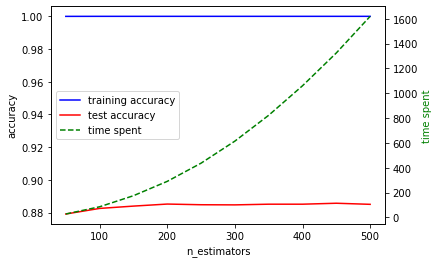

In [40]:
model = "random forest"
parameter = "n_estimators"
lastdate = "20220608" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_rf_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_rf_df[parameter], scores_rf_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_rf_df[parameter], scores_rf_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_rf_df[parameter], scores_rf_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="center left")

output_path =  f"./img/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

#plt.show()
plt.savefig(output_path, dpi=200, facecolor="white")

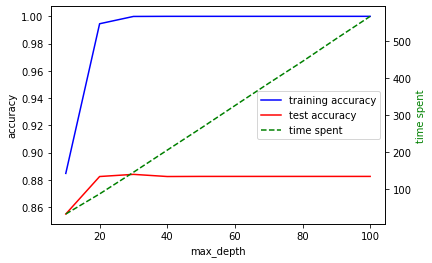

In [39]:
model = "random forest"
parameter = "max_depth"
lastdate = "20220608" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_rf_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_rf_df[parameter], scores_rf_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_rf_df[parameter], scores_rf_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_rf_df[parameter], scores_rf_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="best")

output_path =  f"./img/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

#plt.show()
plt.savefig(output_path, dpi=200, facecolor="white")

## Punto 6: Exploración de modelo Gradient Boosting Machine

In [ ]:
img_folder= "./img"
                
from pathlib import Path
Path(img_folder).mkdir(parents=True, exist_ok=True)

result_folder= "./results"
                
from pathlib import Path
Path(result_folder).mkdir(parents=True, exist_ok=True)

#Falta correr esta parte. 
gb_params = params={'n_estimators': [10,50,100,150,200],
                    'max_depth': [1,3,5,7,9]}

ensemble_exploring(x_train, y_train, x_val, y_val, 
                   model="gradient boosting",
                   params=gb_params,
                   results_folder = result_folder)

#######################################################
### SE REALIZO UN PRIMER INTENTO CON  'n_estimators': [10,50,100,150,200] -> se corto despues de 14 horas incompleto

#  0%|          | 0/2 [00:00<?, ?it/s]
# 
# Exploring gradient boosting classifier
# 100%|██████████| 5/5 [2:30:52<00:00, 1810.41s/it]
# 50%|█████     | 1/2 [2:30:52<2:30:52, 9052.10s/it]
#
# Exploring gradient boosting classifier3
# 30%|███       | 3/10 [20:26:23<47:41:35, 24527.99s/it]
# 50%|█████     | 1/2 [22:57:16<22:57:16, 82636.07s/it]

######################################################

### SE COMPLETO UN SEGUNDO INTENTO CON: 'n_estimators': [10,20,30,40,50]




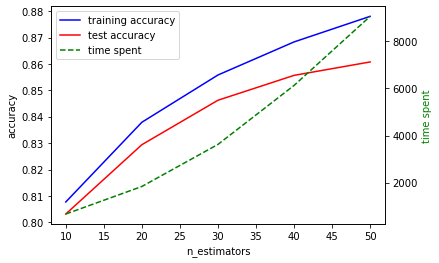

In [38]:
model = "gradient boosting"
parameter = "n_estimators"
lastdate = "20220609" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_gb_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_gb_df[parameter], scores_gb_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_gb_df[parameter], scores_gb_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_gb_df[parameter], scores_gb_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="best")

output_path =  f"./img/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

plt.savefig(output_path, dpi=200, facecolor="white")

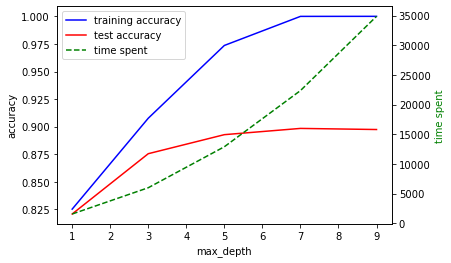

In [37]:
model = "gradient boosting"
parameter = "max_depth"
lastdate = "20220611" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_gb_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_gb_df[parameter], scores_gb_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_gb_df[parameter], scores_gb_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_gb_df[parameter], scores_gb_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="best")

output_path =  f"./img/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

plt.savefig(output_path, dpi=200, facecolor="white")

## Punto 7: Análisis de mejores modelos obtenidos de Random Forest y Gradient Boosting Machine

### Vuelvo a entrenar los modelos anteriores, pero con los hiperparámetros óptimos

PASO 1: Recupero los Conjuntos de Datos originales
* Desarrollo: X_dev, y_dev

* Test: X_test, y_test


In [17]:
# Verificamos conjunto desarrollo -> 60mil registros
X_dev = X_train
y_dev = df_entrenamiento[0]

print(X_dev.shape, ' + ', y_dev.shape)

(60000, 784)  +  (60000,)


In [49]:
# Verificamos conjunto de Test -> 10mil registros

print(X_test.shape, ' + ', y_test.shape)

(10000, 784)  +  (10000,)


PASO 2: Recupero los mejores parametros de cada modelo -> re-entrenamos los modelos usando esos parametros y con todo el dataset de desarrollo

#### Random Forest

In [18]:
# Mejores Parametros Random Forest:
n_estimators_rf = 450
max_depth_rf = 30

print(f'los hiperparámetros óptimos del random forest son nº estimators = {n_estimators_rf} y max_depth = {max_depth_rf}')  # leerlos del csv

# rfo = RandomForestClassifier(random_state = 42, verbose=1, n_jobs=-1, n_estimators=n_estimators_rf, max_depth=max_depth_rf)
# rfo.fit(X_dev, y_dev)
# with open('models/random_forest_opt.pkl', 'wb') as modelFile:
#    pickle.dump(rfo, modelFile)

los hiperparámetros óptimos del random forest son nº estimators = 450 y max_depth = 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.3min finished


RandomForestClassifier(max_depth=30, n_estimators=450, n_jobs=-1,
                       random_state=42, verbose=1)

#### Gradient boosting machines

In [52]:
# Mejores Parametros Gradient Boosting:
n_estimators_gb = 50
max_depth_gb = 7
print(f'los hiperparámetros óptimos del gradient boosting machines son nº estimators = {n_estimators_gb} y max_depth = {max_depth_gb}')  # leerlos del csv

# gbmo = GradientBoostingClassifier(random_state=42, n_estimators = n_estimators_gb, max_depth = max_depth_gb)
# gbmo.fit(X_dev, y_dev)
# with open('models/gradientboostingmachines_opt.pkl', 'wb') as modelFile:
#    pickle.dump(gbmo, modelFile)


los hiperparámetros óptimos del gradient boosting machines son nº estimators = 50 y max_depth = 7


### Evaluación sobre el conjunto de test

In [53]:
# Verificamos conjunto de Test -> 10mil registros

print(X_test.shape, ' + ', y_test.shape)

(10000, 784)  +  (10000,)


Definimos funcion para generar el reporte de metricas:

In [54]:
def preatty_classif_report(y_test, y_pred):
    f = ['accuracy', 'macro_avg', 'weighted_avg']
    nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
    index_rep = nombres + f
        
    dfc= classif_report(y_test, y_pred).round(3)
    dfc.loc[f,'support'] = len(y_test)
    dfc.support = dfc.support.astype(int)
    dfc = dfc[['precision', 'recall', 'f1-score', 'roc_auc', 'support']]
    dfc.index = index_rep
    return dfc

Evaluamos el Modelo de Random Forest

In [3]:
# Predecimos con el modelo de Random Forest optimizado, sobre el conjunto de test original:
with open('models/random_forest_opt.pkl','rb') as modelFile:
     rfo = pickle.load(modelFile)
y_rfpred = rfo.predict(X_test)

/home/nachengue/nacho/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/nachengue/nacho/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Paral

In [56]:
# Analizamos los resultados obtenido, con las metricas de evaluación: accuracy, precision, recall, f1-score, roc_auc
eval_rf = preatty_classif_report(y_test, y_rfpred)
eval_rf

,precision,recall,f1-score,roc_auc,support
T-shirt/top [0],0.825,0.857,0.841,0.918,1000
Trouser [1],0.994,0.962,0.978,0.981,1000
Pullover [2],0.774,0.806,0.789,0.890,1000
Dress [3],0.881,0.914,0.897,0.950,1000
Coat [4],0.769,0.824,0.796,0.898,1000
Sandal [5],0.977,0.958,0.967,0.978,1000
Shirt [6],0.718,0.593,0.650,0.784,1000
Sneaker [7],0.928,0.952,0.940,0.972,1000
Bag [8],0.962,0.975,0.968,0.985,1000
Ankle boot [9],0.953,0.949,0.951,0.972,1000


Evaluamos el Modelo de Gradient Boosting

In [57]:
# # Predecimos con el modelo de Gradient Boosting optimizado, sobre el conjunto de test original:
with open('models/gradientboostingmachines_opt.pkl', 'rb') as modelFile:
    gbmo = pickle.load(modelFile)
y_gbpred = gbmo.predict(X_test)

In [58]:
# Analizamos los resultados obtenido, con las metricas de evaluación: accuracy, precision, recall, f1-score, roc_auc
eval_gb = preatty_classif_report(y_test, y_gbpred)
eval_gb

,precision,recall,f1-score,roc_auc,support
T-shirt/top [0],0.825,0.860,0.842,0.920,1000
Trouser [1],0.993,0.955,0.973,0.977,1000
Pullover [2],0.773,0.796,0.784,0.885,1000
Dress [3],0.878,0.902,0.890,0.944,1000
Coat [4],0.782,0.812,0.797,0.893,1000
Sandal [5],0.976,0.960,0.968,0.979,1000
Shirt [6],0.698,0.623,0.658,0.796,1000
Sneaker [7],0.936,0.955,0.946,0.974,1000
Bag [8],0.963,0.967,0.965,0.981,1000
Ankle boot [9],0.952,0.951,0.951,0.973,1000


### Comparación de modelos y Análisis de resultados en base a métricas elegidas

#### Análisis de métricas

In [61]:
#compilando los dos modelos

gbmo_report = classif_report(y_test, y_gbpred)
rfo_report = classif_report(y_test, y_rfpred)


metric = "f1-score"
nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
index_serie = pd.Series(nombres + ['accuracy',"avg_"+metric])
rfor = rfo_report[metric][:12].reset_index(drop=True)
gbmor = gbmo_report[metric][:12].reset_index(drop=True)

tabla2 = pd.concat([index_serie, rfor, gbmor], axis=1).set_index(0)

tabla2.columns = ['Random Forest','Gradient Boosting']
tabla2.index.name="Class/Metric"
tabla2

,Random Forest,Gradient Boosting
Class/Metric,,
T-shirt/top [0],0.840608,0.841899
Trouser [1],0.977642,0.973496
Pullover [2],0.789422,0.784236
Dress [3],0.897398,0.889985
Coat [4],0.795751,0.796860
Sandal [5],0.967188,0.967742
Shirt [6],0.649507,0.658214
Sneaker [7],0.939783,0.945545
Bag [8],0.968222,0.965070


In [62]:
t2 = tabla2.style.format(precision=3)
print(t2.to_latex(caption="Resumen de Métricas: mejores modelos"))

\begin{table}
\caption{Resumen de Métricas: mejores modelos}
\begin{tabular}{lrr}
 & Random Forest & Gradient Boosting \\
Class/Metric &  &  \\
T-shirt/top [0] & 0.841 & 0.842 \\
Trouser [1] & 0.978 & 0.973 \\
Pullover [2] & 0.789 & 0.784 \\
Dress [3] & 0.897 & 0.890 \\
Coat [4] & 0.796 & 0.797 \\
Sandal [5] & 0.967 & 0.968 \\
Shirt [6] & 0.650 & 0.658 \\
Sneaker [7] & 0.940 & 0.946 \\
Bag [8] & 0.968 & 0.965 \\
Ankle boot [9] & 0.951 & 0.951 \\
accuracy & 0.879 & 0.878 \\
avg_f1-score & 0.878 & 0.877 \\
\end{tabular}
\end{table}



In [30]:
# Comparamos los resultados de los dos modelos:
eval_rf['Rf || Gb'] = '<---||--->'

pd.concat([eval_rf, eval_gb], axis=1)

,precision,recall,f1-score,roc_auc,support,Rf || Gb,precision,recall,f1-score,roc_auc,support
T-shirt/top [0],0.825,0.857,0.841,0.918,1000,<---||--->,0.825,0.860,0.842,0.920,1000
Trouser [1],0.994,0.962,0.978,0.981,1000,<---||--->,0.993,0.955,0.973,0.977,1000
Pullover [2],0.774,0.806,0.789,0.890,1000,<---||--->,0.773,0.796,0.784,0.885,1000
Dress [3],0.881,0.914,0.897,0.950,1000,<---||--->,0.878,0.902,0.890,0.944,1000
Coat [4],0.769,0.824,0.796,0.898,1000,<---||--->,0.782,0.812,0.797,0.893,1000
Sandal [5],0.977,0.958,0.967,0.978,1000,<---||--->,0.976,0.960,0.968,0.979,1000
Shirt [6],0.718,0.593,0.650,0.784,1000,<---||--->,0.698,0.623,0.658,0.796,1000
Sneaker [7],0.928,0.952,0.940,0.972,1000,<---||--->,0.936,0.955,0.946,0.974,1000
Bag [8],0.962,0.975,0.968,0.985,1000,<---||--->,0.963,0.967,0.965,0.981,1000
Ankle boot [9],0.953,0.949,0.951,0.972,1000,<---||--->,0.952,0.951,0.951,0.973,1000


Hay algunas prendas que son difíciles de predecir para ambos modelos, tales como Shirt, Pullover y Coat.

### Conclusión sobre mejor modelo

Como primer análisis, con los hiperparámetros establecidos en el paso anterior, se observa que el modelo RandomForestClassifier tiene un desempeño levemente mayor al del GradientBoostingClassifier. Mientras que el primer modelo obtuvo un accuracy de 0.879, el segundo alcanzó un valor de 0.878. 
Sin embargo, es importante notar que el espacio de búsqueda explorado por el segundo modelo fue realmente acotado por su excesivo tiempo de cómputo. Esto se debe a la cantidad de cálculos que el algoritmo realiza para minimizar su función de costo1. Es por eso que algunos científicos de datos prefieren modelos de boosting que implementen lo que se conoce como Stochastic Gradient Descent. 
Esto implica necesariamente un trade-off entre el tiempo que lleva correr un modelo y su performance predictiva. Ante una diferencia mínima podría seleccionarse cualquiera de los dos modelos, incluso a sabiendas de que el modelo GradientBoostingClassifier tiene espacio para mejorar. Sin embargo, el modelo de RandomForestClassifer posee la ventaja de alcanzar buenas predicciones en un tiempo menor.
Por último, para algunas clases el f1-score del modelo de boosting fue mejor, tales como: Coat [4], Shirt [6], T-shirt/top [0], Sneaker [7]

## Punto 8: Matriz de confusión de mejor modelo y su analisis

In [124]:
# Creamos la matriz de confusion:
from sklearn.metrics import confusion_matrix
import seaborn as sns

nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
clases = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dicc = dict(zip(clases, nombres))


matriz = confusion_matrix(y_test, y_rfpred)
df_mc = pd.DataFrame(matriz, index=nombres, columns=nombres)
#df_mc.index.map(dicc)
#df_mc.columns.map(dicc)

df_mc

,T-shirt/top [0],Trouser [1],Pullover [2],Dress [3],Coat [4],Sandal [5],Shirt [6],Sneaker [7],Bag [8],Ankle boot [9]
T-shirt/top [0],857,0,9,29,5,1,88,0,11,0
Trouser [1],2,962,2,20,4,0,9,0,1,0
Pullover [2],13,0,806,10,116,0,51,0,4,0
Dress [3],15,2,11,914,28,0,28,0,2,0
Coat [4],1,1,89,33,824,0,50,0,2,0
Sandal [5],0,0,0,1,0,958,0,29,1,11
Shirt [6],151,1,123,28,88,0,593,0,16,0
Sneaker [7],0,0,0,0,0,12,0,952,0,36
Bag [8],0,2,2,2,6,2,7,4,975,0
Ankle boot [9],0,0,0,0,0,8,0,41,2,949


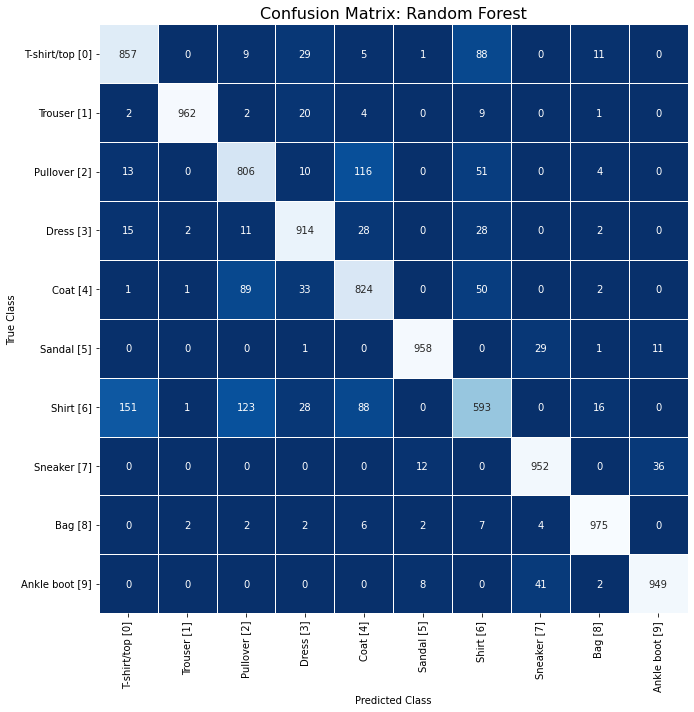

In [126]:
# graficamos la matriz de confusion

plt.figure(figsize=(10,10))
sns.heatmap(df_mc, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None ).set(xlabel='Predicted Class', ylabel='True Class')
plt.title("Confusion Matrix: Random Forest", fontsize=16), plt.tight_layout()
#plt.show()

plt.savefig("./img/confusion_matrix_best_model.png", dpi=200, facecolor="white")

En la diagonal se encuentran la cantidad de clasificaciones correctas para cada una de los tipos prendas. En ella destaca el bajo resultado obtenido en Shirt[6], con apenas 593 casos bien clasificados que, sobre los 1000 casos reales, nos da un bajo recall de 59,3 porciento para esta clase.
Si se analizan las causas, se advierte en la fila correspondiente donde se detalla la clasificación recibida para las 1000 Shirt[6] reales, que se confunde principalmente clasificando 151 veces como T-shirt/top[0], 123 como Pullover[2] y 88 como Coat[4], y a su vez que categoriza como Shirt[6] a prendas de otro tipo, como
los 88 T-shirt/top[0], 51 Pullover[2], 50 Coat[4] y 28 Dress[3]. 
El siguiente caso en bajo desempeño es Pullover[2], con 806 clasificaciones acertadas, explicado principalmente por una tasa de precision en sus predicciones relativamente baja, acertando un 77,4% en un total de 1042 veces, cuando realmente 173 de ellas eran Shirt[6] y otras 89 Coat[4]. Algo similar sucede para las categorizaciones como Coat[4], que arroja 824 casos acertados, pero que dan una tasa de precision aún mas baja de 76,9% sobre 1071 casos, cuando en realidad 116 eran Pullover[2], 88 T-shirt/top[0] y 28 Dress[3]. 
Finalmente se analiza T-shirt/top[0] que alcanza los 857 casos apropiadamente clasificados, obteniendo un 82,5% de precision, donde su error se explica principalmente por los 151 casos que se confunde con Shirt[6]. Para el resto de las clases se observa en la diagonal valores superiores a los 900. Obteniendo para éstas buenas tasas de precision y recuperación que se acercan o superan el 95%, salvo para Dress[3] que llegan a 91,4% y 88,1% en recall y precision respectivamente.

## Punto 9: Estabilidad del modelo frente al ruido

### Dataset con píxeles blancos

In [4]:
p = 0.1 #Proporción de 0s a introducir
n = int(X_test.shape[0]*X_test.shape[1]*p)          #Calculate count of nans. Reemplazar nombre del dataframe

#Sample exactly n indexes
ids = sample(list(product(range(X_test.shape[0]), range(X_test.shape[1]))), n)
idx, idy = list(zip(*ids))

data = X_test.to_numpy().astype(float)            #Get data as numpy
data[idx, idy] = 0                         

#Assign to new dataframe
X_ruido_zeros = pd.DataFrame(data, columns=X_test.columns, index=X_test.index)


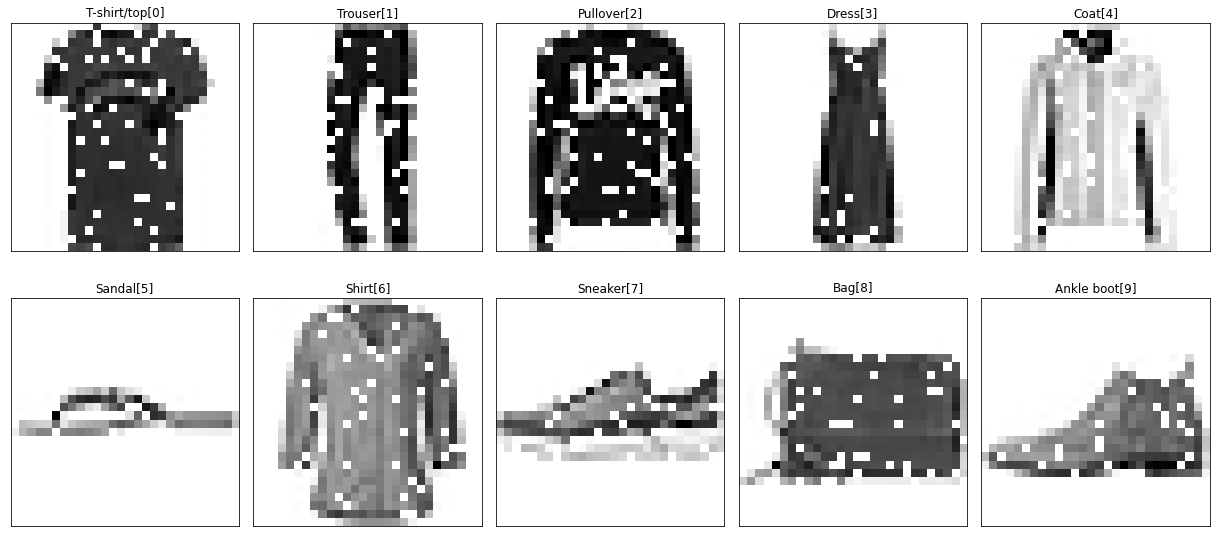

In [5]:
clases = np.sort(df_completo[0].unique())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Ejemplo 1
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_test == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_ruido_zeros[filtro_i].iloc[0]).reshape(28,28),cmap='binary')
plt.tight_layout()
plt.savefig('dataset_ceros')

In [12]:
y_pred = rfo.predict(X_ruido_zeros)
classif_report(y_test, y_pred)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:    0.4s finished


,precision,recall,f1-score,support,roc_auc
0,0.824579,0.8320,0.828273,1000.0000,0.906167
1,0.995838,0.9570,0.976033,1000.0000,0.978278
2,0.771543,0.7700,0.770771,1000.0000,0.872333
3,0.804007,0.9230,0.859404,1000.0000,0.949000
4,0.764535,0.7890,0.776575,1000.0000,0.881000
5,0.882565,0.9770,0.927385,1000.0000,0.981278
6,0.691657,0.5720,0.626163,1000.0000,0.771833
7,0.927492,0.9210,0.924235,1000.0000,0.956500
8,0.948970,0.9670,0.957900,1000.0000,0.980611
9,0.971302,0.8800,0.923400,1000.0000,0.938556


### Dataset con imágenes rotadas 180°

In [6]:
#https://stackoverflow.com/questions/27817718/reverse-dataframe-column-order
X_ruido_rotacion = X_test[X_test.columns[::-1]]

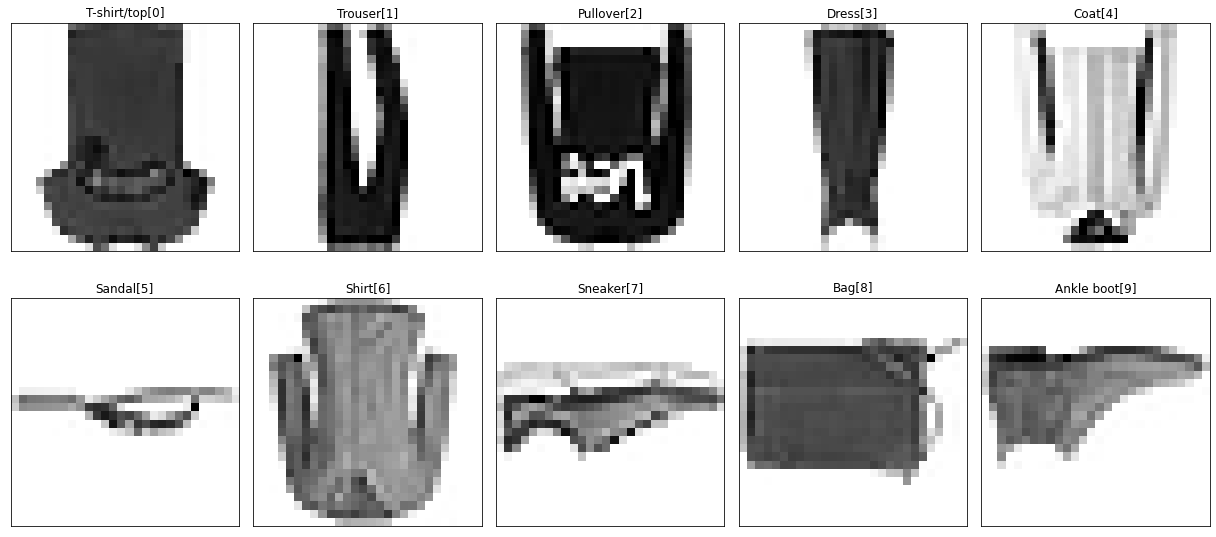

In [7]:
clases = np.sort(df_completo[0].unique())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Ejemplo 1
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_test == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_ruido_rotacion[filtro_i].iloc[0]).reshape(28,28),cmap='binary')
plt.tight_layout()
plt.savefig('dataset_rotado')

In [15]:
y_pred = rfo.predict(X_ruido_rotacion)
classif_report(y_test, y_pred)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:    0.3s finished
C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,roc_auc
0,0.064516,0.0340,0.044532,1000.0000,0.489611
1,0.067114,0.0100,0.017406,1000.0000,0.497278
2,0.168067,0.0200,0.035746,1000.0000,0.504500
3,0.360724,0.7770,0.492708,1000.0000,0.812000
4,0.124700,0.0520,0.073394,1000.0000,0.505722
5,0.941748,0.5820,0.719407,1000.0000,0.789000
6,0.223721,0.7300,0.342482,1000.0000,0.724278
7,0.500000,0.0020,0.003984,1000.0000,0.500889
8,0.214260,0.5890,0.314217,1000.0000,0.674500
9,0.000000,0.0000,0.000000,1000.0000,0.500000


### Dataset con imágenes espejadas

In [8]:
X_copia = X_test.copy()
X_espejado = []
i = 0
for x in range(1,len(X_copia)+1):
    x = X_copia.iloc[i].to_numpy() #Paso ¿fila? a array
    x = x.reshape(28,28) #Doy a cada fila forma 28x28
    img = Image.fromarray(x, 'L') #Paso matrix 28x28 a image, la leo directamente como grayscale
    im_mirror = ImageOps.mirror(img) #Espejo la imagen
    im_mirror_array = np.array(im_mirror) #Paso la imagen nuevamente a array
    im_mirror_array = im_mirror_array.flatten() #Flatten (para revertir el reshape 28x28)
    X_espejado.append(im_mirror_array) #appendeo a X_espejado
    i = i + 1   #Actualizo el contador
X_espejado = np.array(X_espejado)
X_espejado = X_espejado.reshape(10000, 28*28)
X_espejado = pd.DataFrame(X_espejado)
X_espejado.columns = X_test.columns


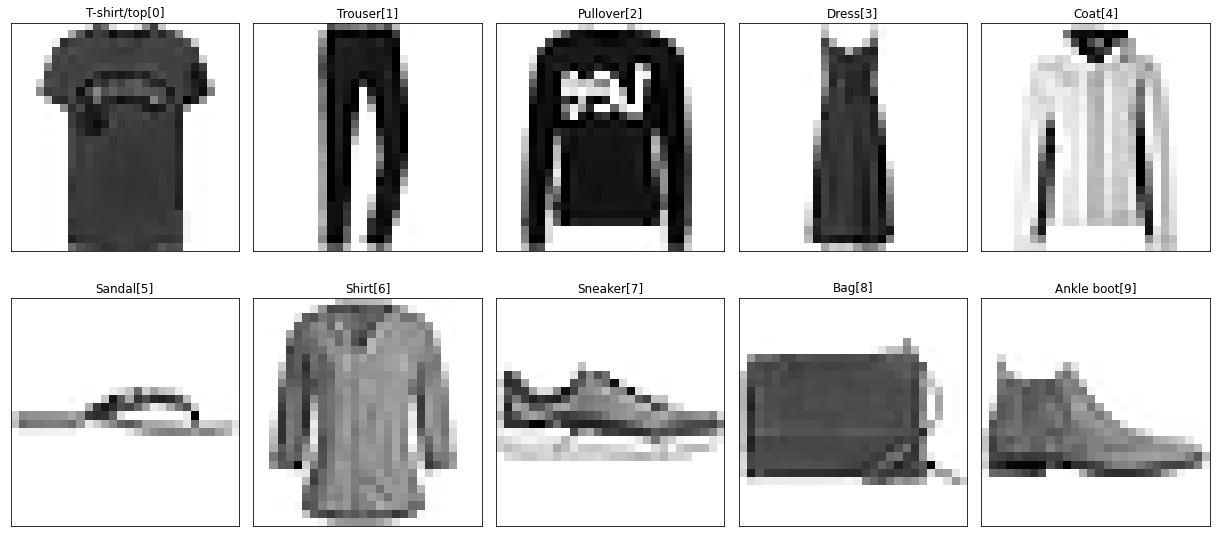

In [9]:
clases = np.sort(df_completo[0].unique())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Ejemplo 1
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_test == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_espejado[filtro_i].iloc[0]).reshape(28,28),cmap='binary')
plt.tight_layout()
plt.savefig('dataset_espejado')

In [18]:
y_pred = rfo.predict(X_espejado)
classif_report(y_test, y_pred)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:    0.4s finished
C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,roc_auc
0,0.812257,0.8350,0.823471,1000.0000,0.906778
1,0.993711,0.9480,0.970317,1000.0000,0.973667
2,0.757663,0.7910,0.773973,1000.0000,0.881444
3,0.838590,0.9040,0.870067,1000.0000,0.942333
4,0.741379,0.8170,0.777355,1000.0000,0.892667
5,0.570768,0.6170,0.592984,1000.0000,0.782722
6,0.581276,0.5650,0.573022,1000.0000,0.759889
7,0.961538,0.2000,0.331126,1000.0000,0.599556
8,0.380576,0.9640,0.545712,1000.0000,0.894833
9,0.000000,0.0000,0.000000,1000.0000,0.500000


### Dataset en base a imágenes nuevas

Link en Drive de subset de imágenes: https://drive.google.com/drive/folders/1XoDDz-w7M86lsezfY4qnwdToS_8KpdoM?usp=sharing
Colocar archivos en data/clothing-dataset-subset/

In [10]:
#Cargo directorio de imágenes
images = glob.glob("data/clothing-dataset-subset/*.jpg")
#Guardo total de imagenes a parsear
n_images = len(images)

#Inicializo arrays
array_X_newclothing = []
array_X_newclothing_names = []
#Patron para extraer nombre de imágenes
patron = "data/clothing-dataset-subset\\\(.*?).jpg"

#Este loop:
# Abre cada imagen, cambia su tamaño en pixeles a 28x28 y las pasa a greyscale
# Guarda en el array array_X_newclothing cada imagen
# Guarda en array_X_newclothing_names cada nombre de imagen. Lo vamos a necesitar para asociarlas a la categoría a la que corresponden

for i in images:
    fileImage = Image.open(i).convert("L").resize([28,28],Image.ANTIALIAS)
    array_fileImage = np.array(fileImage)
    array_X_newclothing.append(array_fileImage)
    fileName = re.findall(patron, i)
    array_X_newclothing_names.append(fileName)

In [11]:
array_X_newclothing = np.array(array_X_newclothing)
X_newclothing = array_X_newclothing.reshape(n_images,28*28)
X_newclothing.shape

(2942, 784)

In [12]:
url_labels = 'https://raw.githubusercontent.com/alexeygrigorev/clothing-dataset/master/images.csv'
df = pd.read_csv(url_labels)
df.drop(['sender_id', 'kids'], axis=1, inplace=True)
df.columns = ['filename' if x=='image' else x for x in df.columns]
df.label.value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

In [13]:
#Recodifico nombres de ropa y las asocio a labels
df.label[df.label=="T-Shirt"] = 0
df.label[df.label=="Pants"] = 1
df.label[df.label=="Longsleeve"] = 2
df.label[df.label=="Dress"] = 3
df.label[df.label=="Outwear"] = 4
df.label[df.label=="Shirt"] = 6

#Elimino todas las imágenes que no correspondan a las labels recodificadas (numéricas)
df = df[pd.to_numeric(df['label'], errors='coerce').notnull()]
df.label.value_counts()

0    1011
2     699
1     692
6     378
3     357
4     312
Name: label, dtype: int64

In [14]:
X_nc = pd.DataFrame(X_newclothing)
X_nc['filename'] = array_X_newclothing_names
X_nc['filename'] = X_nc['filename'].str[0]
X_nc = pd.merge(X_nc, df, on ="filename")
Y_nc = X_nc['label']
X_nc.drop(['label', 'filename'], axis=1, inplace=True)
X_nc =  pd.DataFrame(data=X_nc.values, columns=X_train.columns)

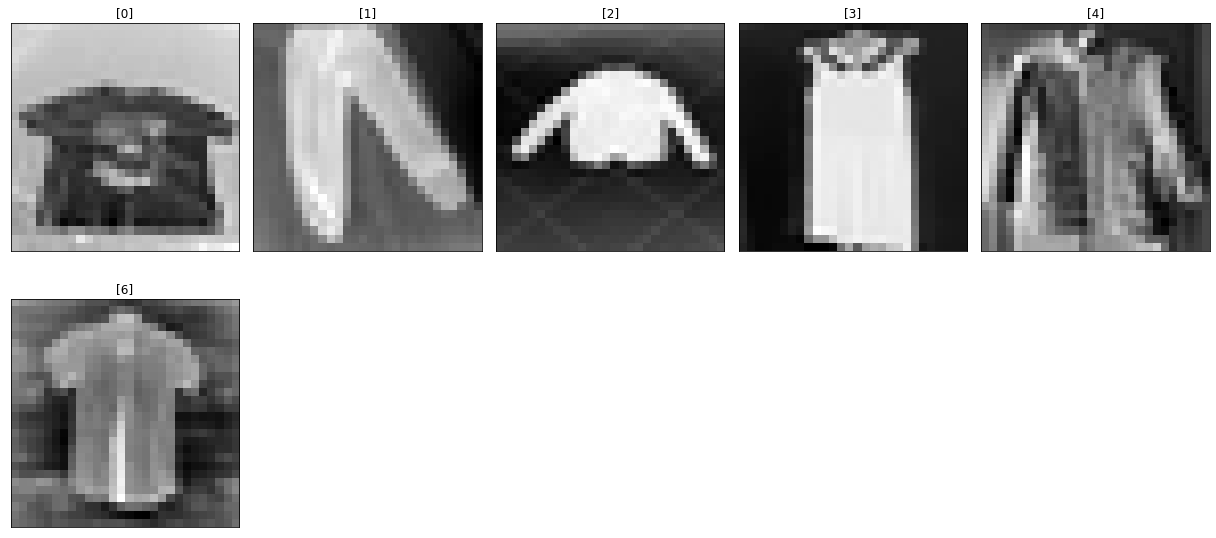

In [15]:
clases = [0,1,2,3,4,6]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Outwear', 'Shirt']


## Ejemplo 1
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = Y_nc == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_nc[filtro_i].iloc[0]).reshape(28,28),cmap='binary')
plt.tight_layout()
plt.savefig('dataset_nuevo')

In [19]:
y_pred = rfo.predict(X_nc)
accuracy = (Y_nc == y_pred).sum() / len(Y_nc)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:    0.0s finished


In [20]:
print(accuracy)

0.018021081264875893


In [35]:
df = pd.DataFrame()
df['clase_verdadera'] = Y_nc
df['clase_predicha'] = y_pred
df['acierto'] = Y_nc==y_pred
df

,clase_verdadera,clase_predicha,acierto
0,0,8,False
1,6,8,False
2,4,8,False
3,4,6,False
4,4,8,False
...,...,...,...
2936,0,8,False
2937,0,8,False
2938,0,8,False
2939,1,6,False


In [40]:
df_agrupado = df.groupby(['clase_verdadera', 'acierto']).count()
df_agrupado

clase_predicha
clase_verdadera acierto                
0               False               929
1               False               560
2               False               582
                True                  3
3               False               287
4               False               236
6               False               294
                True                 50

## Punto 10: Redes Neuronales

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras.datasets import fashion_mnist

(dev_images, dev_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

ohe = OneHotEncoder()
dev_labels = ohe.fit_transform(dev_labels.reshape(-1,1)).toarray()
test_labels = ohe.fit_transform(test_labels.reshape(-1,1)).toarray()

train_images,val_images,train_labels,val_labels = train_test_split(dev_images,dev_labels,test_size=0.2)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-06-20 03:41:24.871708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 03:41:25.745558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 03:41:25.746915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 03:41:25.790695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
#Voy a hacer una prueba para que teste distintas cantidades de neuronas en la capa oculta
# y además utilice distintas funciones de activación. 
#por otro lado tambien optimiza el batch size. 

def entrenar_modelo(hparams, model_name):
  layer_in = tfkl.Input(shape=(28,28)) #Todo modelo necesita una entrada, y debemos especificar sus dimensiones
  layer_add_channel = tf.expand_dims(layer_in,axis=3)
  conv_block1 = tfkl.Conv2D(16,(3,3),padding='SAME',activation='relu')(layer_add_channel)
  conv_block1 = tfkl.Conv2D(16,(3,3),padding='SAME',activation='relu')(conv_block1)
  pool_1 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block1) #Aca queda (14,14)
  conv_block2 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(pool_1)
  conv_block2 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(conv_block2)
  pool_2 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block2) #Aca queda (7,7)
  conv_block3 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(pool_2)
  conv_block3 = tfkl.Conv2D(8,(3,3),padding='SAME',activation='relu')(conv_block3)
  #Esta capa rompe la imagen achicada (8,7,7) y la vuelve un vector de 392 elementos
  flatten_layer = tfkl.Flatten()(conv_block3)
  hidden_layer = tfkl.Dense(units=hparams['units'], activation=hparams['activation'])(flatten_layer)
  #Esta es la capa de salida
  output_layer = tfkl.Dense(units=10,activation='softmax')(flatten_layer)

  conv2d_model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])
  

  optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['learning_rate'])
  metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.AUC()]
  metric_names = ['loss','acc','precision','recall','auc']
  conv2d_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics_list)
  filepath = f"fashion_mnist-{model_name}.hdf5" 

  cb_list = [tf.keras.callbacks.TensorBoard(log_dir='tblogs'),
              tf.keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor = "val_loss", verbose=1,
                                                 save_best_only=True),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]

  start = time.time()
  conv2d_model.fit(x=train_images,y=train_labels,validation_data=(val_images,val_labels),batch_size=hparams['batch_size'],epochs=50,callbacks=cb_list)
  elapsed_time = time.time() - start
  performance = conv2d_model.evaluate(x=val_images,y=val_labels)
  performance = dict(zip(metric_names,performance))

  return conv2d_model, performance, hparams, elapsed_time

In [9]:
# from sklearn.model_selection import ParameterSampler

# hyperparameter_space= {'units': [32,56,128,512,1024,2048,4096,8192],
#           'activation': ['relu','tanh','sigmoid','elu'],
#           'batch_size':[16,32,64,128,256,512],
#           'learning_rate':[0.0001,0.001,0.01]}
# hyperparameters = list(ParameterSampler(hyperparameter_space,n_iter=10))

# best_recall = 0
# best_model = None
# best_params = None
# hyp_results = []
# for model_name, hparam in tqdm(enumerate(hyperparameters)):
#   model, perf, hparams, elapsed_time = entrenar_modelo(hparam ,model_name=str(model_name+1))
#   hyp_results.append({'model_name':model_name,'params': hparams,'performance': perf, 'elapsed_time': elapsed_time})  
#   if perf['acc'] > best_acc:
#     best_acc = perf['acc']
#     best_model = model
#     model.save_weights(f'./best_conv2d/model_{model_name}.ckpt')

# hyp_results_df = pd.DataFrame(hyp_results)
# hyp_results_df = pd.concat([hyp_results_df[['model_name','params','elapsed_time']], hyp_results_df['performance'].apply(pd.Series)], axis=1)
# hoy = datetime.now().strftime("%Y%m%d")
# hyp_results_df.to_csv(f"./results/conv2d_hypopt_{hoy}.csv", index=False)

In [7]:
hyp_results_df = pd.read_csv(f"./results/conv2d_hypopt_20220612.csv")
hyp_results_df

,model_name,params,elapsed_time,loss,acc,precision,recall,auc
0,0,"{'units': 56, 'learning_rate': 0.0001, 'batch_...",1191.423954,0.295286,0.898667,0.909323,0.890000,0.992898
1,1,"{'units': 128, 'learning_rate': 0.0001, 'batch...",16570.518286,0.314543,0.892333,0.904477,0.882167,0.992367
2,2,"{'units': 4096, 'learning_rate': 0.0001, 'batc...",1270.951972,0.329850,0.885333,0.897436,0.875000,0.991387
3,3,"{'units': 32, 'learning_rate': 0.01, 'batch_si...",617.385063,0.410689,0.851583,0.886163,0.812833,0.989396
4,4,"{'units': 512, 'learning_rate': 0.01, 'batch_s...",477.821110,0.622271,0.759667,0.804403,0.715583,0.976786
5,5,"{'units': 56, 'learning_rate': 0.0001, 'batch_...",2343.354022,0.309517,0.896083,0.907135,0.888917,0.991615
6,6,"{'units': 4096, 'learning_rate': 0.001, 'batch...",623.689023,0.292821,0.906417,0.911663,0.902167,0.991529
7,7,"{'units': 32, 'learning_rate': 0.01, 'batch_si...",24007.940646,0.527349,0.803250,0.839993,0.767333,0.982578
8,8,"{'units': 32, 'learning_rate': 0.0001, 'batch_...",1614.853620,0.318445,0.892583,0.906584,0.882333,0.991941
9,9,"{'units': 1024, 'learning_rate': 0.0001, 'batc...",1807.543514,0.314800,0.893083,0.908288,0.883083,0.991766


Entreno usando los mejores parámetros con el datateset de desarrollo completo. 

In [25]:
import json
model_name = 6
idx = hyp_results_df[hyp_results_df.model_name==model_name].index[0]
best_params = json.loads(hyp_results_df.loc[idx,'params'].replace("'",'"'))
best_params  

{'units': 4096, 'learning_rate': 0.001, 'batch_size': 64, 'activation': 'tanh'}

In [10]:
def create_model(hparams):
  layer_in = tfkl.Input(shape=(28,28)) #Todo modelo necesita una entrada, y debemos especificar sus dimensiones
  layer_add_channel = tf.expand_dims(layer_in,axis=3)
  conv_block1 = tfkl.Conv2D(16,(3,3),padding='SAME',activation='relu')(layer_add_channel)
  conv_block1 = tfkl.Conv2D(16,(3,3),padding='SAME',activation='relu')(conv_block1)
  pool_1 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block1) #Aca queda (14,14)
  conv_block2 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(pool_1)
  conv_block2 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(conv_block2)
  pool_2 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block2) #Aca queda (7,7)
  conv_block3 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(pool_2)
  conv_block3 = tfkl.Conv2D(8,(3,3),padding='SAME',activation='relu')(conv_block3)
  #Esta capa rompe la imagen achicada (8,7,7) y la vuelve un vector de 392 elementos
  flatten_layer = tfkl.Flatten()(conv_block3)
  hidden_layer = tfkl.Dense(units=hparams['units'], activation=hparams['activation'])(flatten_layer)
  #Esta es la capa de salida
  output_layer = tfkl.Dense(units=10,activation='softmax')(flatten_layer)
  conv2d_model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])
  return conv2d_model

m = create_model(best_params)

# tf.keras.utils.plot_model(
#     m,
#     to_file='./img/conv2d_model.png',
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False
# )

In [11]:
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
==
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 28, 28, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                          

In [27]:
#cargo de nuevo de esta manera porque skf no funciona con multilabel-indicator
(dev_images_, dev_labels_), (test_images_, test_labels_) = fashion_mnist.load_data()

In [28]:
dev_labels_

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Corremos un 5-fold cross-validation para estimar un accuracy promedio de este mejor modelo. 

In [31]:
from sklearn.model_selection import StratifiedKFold

#cargo de nuevo de esta manera porque skf no funciona con multilabel-indicator
(dev_images_, dev_labels_), (test_images_, test_labels_) = fashion_mnist.load_data()



folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=None)

histories = []
i = 1
for train_index, val_index in tqdm(skf.split(dev_images_, dev_labels_)):
    # Saving the best checkpoint for each iteration
    filepath = "checkpoints/fashion_mnist-%i.hdf5" % i
    
    train_images, val_images = dev_images_[train_index], dev_images_[val_index]
    train_labels, val_labels = dev_labels_[train_index], dev_labels_[val_index]
    
    ohe = OneHotEncoder()
    train_labels = ohe.fit_transform(train_labels.reshape(-1,1)).toarray() #aca obtengo las labels en vecs de 10 elem.
    val_labels = ohe.fit_transform(val_labels.reshape(-1,1)).toarray() #aca obtengo las labels en vecs de 10 elem.
    conv2d_model = create_model(best_params)
    cb_list = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
    metrics_list = [tf.keras.metrics.CategoricalAccuracy()]
    conv2d_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics_list)
    history = conv2d_model.fit(x=train_images,y=train_labels,
                               validation_data=(val_images,val_labels),
                               batch_size=best_params['batch_size'],
                               epochs=50,
                               callbacks=cb_list,
                               verbose=1)
    histories.append((i,history))
    i = i +1

0it [00:00, ?it/s]

Epoch 1/50
749/750 [>.] - ETA: 0s - loss: 0.5559 - categorical_accuracy: 0.8075
Epoch 1: val_loss improved from inf to 0.37413, saving model to checkpoints/fashion_mnist-1.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.5556 - categorical_accuracy: 0.8076 - val_loss: 0.3741 - val_categorical_accuracy: 0.8662
Epoch 2/50
750/750 [==] - ETA: 0s - loss: 0.3484 - categorical_accuracy: 0.8767
Epoch 2: val_loss improved from 0.37413 to 0.32328, saving model to checkpoints/fashion_mnist-1.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.3484 - categorical_accuracy: 0.8767 - val_loss: 0.3233 - val_categorical_accuracy: 0.8857
Epoch 3/50
749/750 [>.] - ETA: 0s - loss: 0.3015 - categorical_accuracy: 0.8918
Epoch 3: val_loss did not improve from 0.32328
750/750 [==] - 19s 25ms/step - loss: 0.3017 - categorical_accuracy: 0.8917 - val_loss: 0.3352 - val_categorical_accuracy: 0.8826
Epoch 4/50
748/750 [>.] - ETA: 0s - loss: 0.2754 - categorical_accuracy: 0.8992
Epoch 4: val_loss improved from 0.32328 to 0.277

1it [04:26, 266.20s/it]

Epoch 1/50
750/750 [==] - ETA: 0s - loss: 0.5434 - categorical_accuracy: 0.8170
Epoch 1: val_loss improved from inf to 0.37056, saving model to checkpoints/fashion_mnist-2.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.5434 - categorical_accuracy: 0.8170 - val_loss: 0.3706 - val_categorical_accuracy: 0.8656
Epoch 2/50
749/750 [>.] - ETA: 0s - loss: 0.3351 - categorical_accuracy: 0.8819
Epoch 2: val_loss improved from 0.37056 to 0.32912, saving model to checkpoints/fashion_mnist-2.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.3351 - categorical_accuracy: 0.8819 - val_loss: 0.3291 - val_categorical_accuracy: 0.8834
Epoch 3/50
748/750 [>.] - ETA: 0s - loss: 0.2926 - categorical_accuracy: 0.8949
Epoch 3: val_loss improved from 0.32912 to 0.32261, saving model to checkpoints/fashion_mnist-2.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.2928 - categorical_accuracy: 0.8948 - val_loss: 0.3226 - val_categorical_accuracy: 0.8827
Epoch 4/50
748/750 [>.] - ETA: 0s - loss: 0.2633 - categorical_accuracy: 0

2it [08:52, 266.21s/it]

Epoch 1/50
750/750 [==] - ETA: 0s - loss: 0.5557 - categorical_accuracy: 0.8086
Epoch 1: val_loss improved from inf to 0.38247, saving model to checkpoints/fashion_mnist-3.hdf5
750/750 [==] - 20s 26ms/step - loss: 0.5557 - categorical_accuracy: 0.8086 - val_loss: 0.3825 - val_categorical_accuracy: 0.8633
Epoch 2/50
748/750 [>.] - ETA: 0s - loss: 0.3436 - categorical_accuracy: 0.8777
Epoch 2: val_loss did not improve from 0.38247
750/750 [==] - 19s 25ms/step - loss: 0.3439 - categorical_accuracy: 0.8776 - val_loss: 0.3947 - val_categorical_accuracy: 0.8529
Epoch 3/50
749/750 [>.] - ETA: 0s - loss: 0.3030 - categorical_accuracy: 0.8914
Epoch 3: val_loss improved from 0.38247 to 0.31712, saving model to checkpoints/fashion_mnist-3.hdf5
750/750 [==] - 19s 26ms/step - loss: 0.3029 - categorical_accuracy: 0.8914 - val_loss: 0.3171 - val_categorical_accuracy: 0.8821
Epoch 4/50
748/750 [>.] - ETA: 0s - loss: 0.2723 - categorical_accuracy: 0.9013
Epoch 4: val_loss improved from 0.31712 to 0.296

3it [13:39, 275.65s/it]

Epoch 1/50
750/750 [==] - ETA: 0s - loss: 0.5525 - categorical_accuracy: 0.8130
Epoch 1: val_loss improved from inf to 0.38742, saving model to checkpoints/fashion_mnist-4.hdf5
750/750 [==] - 20s 26ms/step - loss: 0.5525 - categorical_accuracy: 0.8130 - val_loss: 0.3874 - val_categorical_accuracy: 0.8584
Epoch 2/50
748/750 [>.] - ETA: 0s - loss: 0.3409 - categorical_accuracy: 0.8753
Epoch 2: val_loss improved from 0.38742 to 0.34214, saving model to checkpoints/fashion_mnist-4.hdf5
750/750 [==] - 19s 26ms/step - loss: 0.3413 - categorical_accuracy: 0.8752 - val_loss: 0.3421 - val_categorical_accuracy: 0.8813
Epoch 3/50
750/750 [==] - ETA: 0s - loss: 0.2988 - categorical_accuracy: 0.8922
Epoch 3: val_loss improved from 0.34214 to 0.29073, saving model to checkpoints/fashion_mnist-4.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.2988 - categorical_accuracy: 0.8922 - val_loss: 0.2907 - val_categorical_accuracy: 0.8968
Epoch 4/50
750/750 [==] - ETA: 0s - loss: 0.2696 - categorical_accuracy: 0

4it [17:29, 257.61s/it]

Epoch 1/50
748/750 [>.] - ETA: 0s - loss: 0.4980 - categorical_accuracy: 0.8224
Epoch 1: val_loss improved from inf to 0.37795, saving model to checkpoints/fashion_mnist-5.hdf5
750/750 [==] - 20s 26ms/step - loss: 0.4978 - categorical_accuracy: 0.8225 - val_loss: 0.3780 - val_categorical_accuracy: 0.8618
Epoch 2/50
750/750 [==] - ETA: 0s - loss: 0.3235 - categorical_accuracy: 0.8861
Epoch 2: val_loss improved from 0.37795 to 0.32529, saving model to checkpoints/fashion_mnist-5.hdf5
750/750 [==] - 19s 26ms/step - loss: 0.3235 - categorical_accuracy: 0.8861 - val_loss: 0.3253 - val_categorical_accuracy: 0.8836
Epoch 3/50
748/750 [>.] - ETA: 0s - loss: 0.2817 - categorical_accuracy: 0.8985
Epoch 3: val_loss improved from 0.32529 to 0.29396, saving model to checkpoints/fashion_mnist-5.hdf5
750/750 [==] - 19s 25ms/step - loss: 0.2818 - categorical_accuracy: 0.8985 - val_loss: 0.2940 - val_categorical_accuracy: 0.8938
Epoch 4/50
748/750 [>.] - ETA: 0s - loss: 0.2556 - categorical_accuracy: 0

5it [21:37, 259.52s/it]


In [33]:
histories

[(1, <keras.callbacks.History at 0x7f327a941610>),
 (2, <keras.callbacks.History at 0x7f329968acd0>),
 (3, <keras.callbacks.History at 0x7f32982fa6a0>),
 (4, <keras.callbacks.History at 0x7f3298353160>),
 (5, <keras.callbacks.History at 0x7f327b473e50>)]

In [35]:
def get_avg(histories, his_key):
    tmp = []
    for i,history in histories:
        tmp.append(history.history[his_key][np.argmin(history.history['val_loss'])]) #obtengo el dato que tenga menor val_loss
    return np.mean(tmp)
    
print('Training: \t%0.3f loss / %0.3f acc'   % (get_avg(histories,'loss'), get_avg(histories,'categorical_accuracy')))
print('Validation: \t%0.3f loss / %0.3f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_categorical_accuracy')))

Training: 	0.206 loss / 0.924 acc
Validation: 	0.264 loss / 0.907 acc


In [36]:
test_loss = []
test_accs = []

for i in range(1,folds+1):
    conv2d_ = tf.keras.models.load_model("checkpoints/fashion_mnist-%i.hdf5" % i) #carga modelo desde checkpoints
    
    score = conv2d_.evaluate(test_images, test_labels, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i,score[0],score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

Running final test with model 1: 0.2884 loss / 0.9039 acc
Running final test with model 2: 0.2981 loss / 0.8924 acc
Running final test with model 3: 0.2850 loss / 0.9047 acc
Running final test with model 4: 0.2917 loss / 0.9027 acc
Running final test with model 5: 0.2802 loss / 0.9000 acc

Average loss / accuracy on testset: 0.2887 loss / 0.90074 acc
Standard deviation: (+-0.0060) loss / (+-0.0045) acc


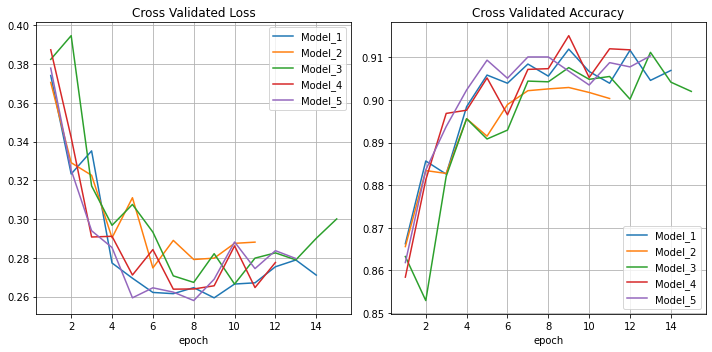

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

for i, history in histories: 
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['categorical_accuracy'], history.history['val_categorical_accuracy']

    epoch_max = np.argmax(val_acc)
    val_acc_max = val_acc[epoch_max]

    epochs = np.arange(1,len(loss)+1,1)
    ax1.plot(epochs, val_loss, label="Model_%i" %i)
    ax1.set_title("Cross Validated Loss")
    ax1.set_xlabel('epoch')
    ax1.grid()
    ax1.legend()

    ax2.plot(epochs, val_acc, label="Model_%i" %i)
    ax2.set_title("Cross Validated Accuracy")
    ax2.set_xlabel('epoch')
    ax2.grid()
    ax2.legend()

# ax2.annotate('Val Acc Max. {:.4f}'.format(val_acc_max), xy=(epoch_max, val_acc_max),  xycoords='data',
#             xytext=(7, 0.86), textcoords='data',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )

plt.tight_layout()
#plt.show()
plt.savefig("./img/loss-acc-cross_val.png", dpi=200, facecolor="w")
             

In [42]:
print("Evaluate model on test data")
conv2d_model = create_model(best_params)
b_list = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
          tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
metrics_list = [tf.keras.metrics.CategoricalAccuracy()]
conv2d_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics_list)
conv2d_model.load_weights("./checkpoints/fashion_mnist-%i.hdf5" % 3)
results = conv2d_model.evaluate(test_images, test_labels, batch_size=64)
print("test loss, test acc:", results)

Evaluate model on test data
157/157 [==] - 2s 10ms/step - loss: 0.2850 - categorical_accuracy: 0.9047
test loss, test acc: [0.2850237190723419, 0.904699981212616]


In [73]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    epoch_max = np.argmax(history.history['val_categorical_accuracy'])
    val_acc_max = history.history['val_categorical_accuracy'][epoch_max]
    
    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax1.grid()

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')
    ax2.grid()
    
   

    plt.tight_layout()
    plt.savefig("./img/loss-acc-mejor_modelo.png", dpi=200, facecolor="w")

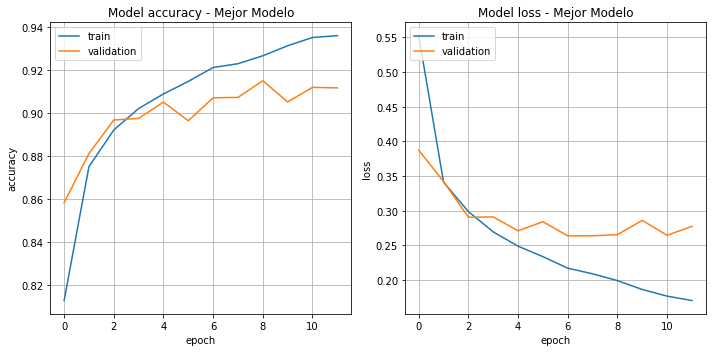

In [74]:
plot_train_val('Mejor Modelo', histories[3][1])

In [61]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = conv2d_model.predict(test_images)

Generate a prediction
313/313 [==] - 1s 4ms/step


In [62]:
prediction #salida softmax 

array([[1.09324958e-06, 8.48781951e-08, 1.76792042e-07, ...,
        8.79779691e-04, 5.26147869e-06, 9.99108255e-01],
       [1.42548806e-05, 8.37443093e-09, 9.96721685e-01, ...,
        1.35899247e-09, 3.91455712e-09, 1.04236584e-08],
       [9.62087370e-07, 9.99986410e-01, 6.09368442e-07, ...,
        4.45870452e-10, 2.33485853e-08, 1.87140199e-11],
       ...,
       [6.85433799e-09, 3.52842165e-11, 1.43453761e-07, ...,
        9.70477951e-12, 9.99999642e-01, 3.36492206e-12],
       [5.97011081e-08, 9.99999762e-01, 9.95529774e-08, ...,
        8.01184409e-15, 8.57591428e-12, 3.36837390e-14],
       [5.56602463e-05, 3.72849922e-06, 5.16719883e-04, ...,
        1.16665855e-01, 1.04381457e-01, 1.41974178e-03]], dtype=float32)

In [63]:
ypreds = np.argmax(prediction, axis = 1)
ytest = np.argmax(test_labels, axis = 1)

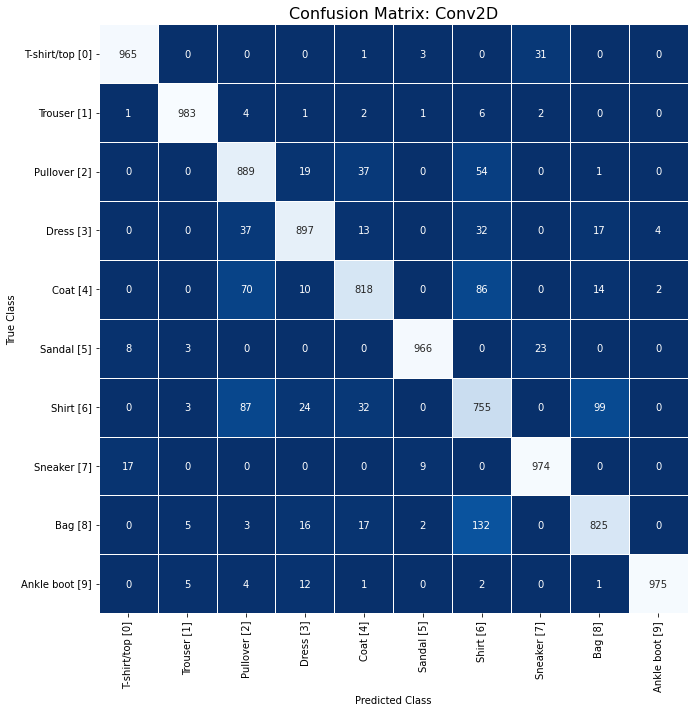

In [64]:
nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
clases = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dicc = dict(zip(clases, nombres))


matriz = confusion_matrix(pd.Series(ytest).map(dicc),pd.Series(ypreds).map(dicc))
df_mc = pd.DataFrame(matriz, index=nombres, columns=nombres)

plt.figure(figsize=(10,10))
sns.heatmap(df_mc, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None ).set(xlabel='Predicted Class', ylabel='True Class')
plt.title("Confusion Matrix: Conv2D", fontsize=16), plt.tight_layout()
#plt.show()

plt.savefig("./img/confusion_matrix_conv2d_model.png", dpi=200, facecolor="white")

## Conv2d vs RF

In [128]:
ypreds

array([9, 2, 1, ..., 8, 1, 5])

In [65]:
y_rfpred

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [130]:
ytest

array([9, 2, 1, ..., 8, 1, 5])

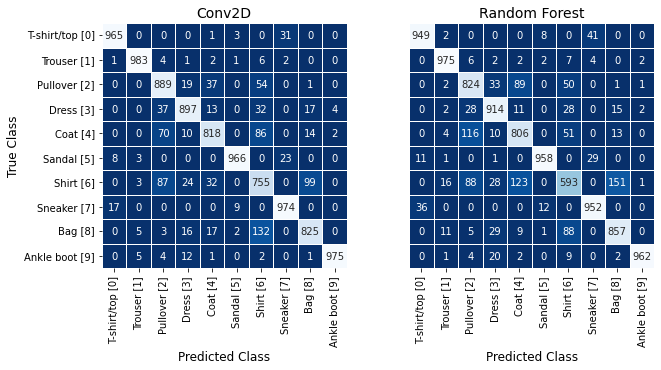

In [66]:
nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
clases = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dicc = dict(zip(clases, nombres))


#CONV2D
mconv2d = confusion_matrix(pd.Series(ytest).map(dicc),pd.Series(ypreds).map(dicc))
mconv2d = pd.DataFrame(mconv2d, index=nombres, columns=nombres)

#Random Forest
mrf = confusion_matrix(pd.Series(ytest).map(dicc),pd.Series(y_rfpred).map(dicc))
mrf = pd.DataFrame(mrf, index=nombres, columns=nombres)

import matplotlib.ticker as ticker
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

h1 = sns.heatmap(mconv2d, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None, ax=axs[0])
axs[0].set_xlabel('Predicted Class', fontsize=12)
axs[0].set_ylabel('True Class', fontsize=12)
axs[0].set_title("Conv2D", fontsize=14)

hs = sns.heatmap(mrf, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None, ax=axs[1])
axs[1].set_xlabel('Predicted Class', fontsize=12)
axs[1].set_title("Random Forest", fontsize=14)
axs[1].yaxis.set_major_locator(ticker.NullLocator())

plt.tight_layout()
# plt.show()
plt.savefig("./img/confusion_matrix_conv2d_vs_rf.png", dpi=200, facecolor="white")

In [76]:
conv_report = classif_report(y_test, ypreds)
rfo_report = classif_report(y_test, y_rfpred)


metric = "f1-score"
nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
index_serie = pd.Series(nombres + ['accuracy',"avg_"+metric])
rfor = rfo_report[metric][:12].reset_index(drop=True)
convr = conv_report[metric][:12].reset_index(drop=True)

tabla3 = pd.concat([index_serie, convr, rfor], axis=1).set_index(0)

tabla3.columns = ['Conv2D','Random Forest']
tabla3.index.name="Class/Metric"
tabla3

,Conv2D,Random Forest
Class/Metric,,
T-shirt/top [0],0.843127,0.840608
Trouser [1],0.984351,0.977642
Pullover [2],0.851640,0.789422
Dress [3],0.906518,0.897398
Coat [4],0.849093,0.795751
Sandal [5],0.975265,0.967188
Shirt [6],0.730527,0.649507
Sneaker [7],0.959606,0.939783
Bag [8],0.983492,0.968222


In [78]:
t3 = tabla3.style.format(precision=3)
print(t3.to_latex(caption="Resumen de Métricas: Conv2d vs RandomForest"))

\begin{table}
\caption{Resumen de Métricas: Conv2d vs RandomForest}
\begin{tabular}{lrr}
 & Conv2D & Random Forest \\
Class/Metric &  &  \\
T-shirt/top [0] & 0.843 & 0.841 \\
Trouser [1] & 0.984 & 0.978 \\
Pullover [2] & 0.852 & 0.789 \\
Dress [3] & 0.907 & 0.897 \\
Coat [4] & 0.849 & 0.796 \\
Sandal [5] & 0.975 & 0.967 \\
Shirt [6] & 0.731 & 0.650 \\
Sneaker [7] & 0.960 & 0.940 \\
Bag [8] & 0.983 & 0.968 \\
Ankle boot [9] & 0.969 & 0.951 \\
accuracy & 0.905 & 0.879 \\
avg_f1-score & 0.905 & 0.878 \\
\end{tabular}
\end{table}

